# Contact Prediction Examples

This example shows contact prediction with the ESM-1b and MSA Transformer models. Contact prediction is based on a logistic regression over the model's attention maps. This methodology is based on our ICLR 2021 paper, "Transformer protein language models are unsupervised structure learners." (https://www.biorxiv.org/content/10.1101/2020.12.15.422761v1).

In [1]:
import matplotlib.pyplot as plt
import esm
import torch
import os
from Bio import SeqIO
import itertools
from typing import List, Tuple
import string


In [2]:
torch.set_grad_enabled(False)

## Data Loading

This sets up some sequence loading utilities for ESM-1b (`read_sequence`) and the MSA Transformer (`read_msa`).

In [3]:
# This is an efficient way to delete lowercase characters and insertion characters from a string
deletekeys = dict.fromkeys(string.ascii_lowercase)
deletekeys["."] = None
deletekeys["*"] = None
translation = str.maketrans(deletekeys)

def read_sequence(filename: str) -> Tuple[str, str]:
    """ Reads the first (reference) sequences from a fasta or MSA file."""
    record = next(SeqIO.parse(filename, "fasta"))
    return record.description, str(record.seq)

def remove_insertions(sequence: str) -> str:
    """ Removes any insertions into the sequence. Needed to load aligned sequences in an MSA. """
    return sequence.translate(translation)

def read_msa(filename: str, nseq: int) -> List[Tuple[str, str]]:
    """ Reads the first nseq sequences from an MSA file, automatically removes insertions."""
    return [(record.description, remove_insertions(str(record.seq)))
            for record in itertools.islice(SeqIO.parse(filename, "fasta"), nseq)]

## Run ESM-1b Contact Prediction

In [4]:
esm1b, esm1b_alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
esm1b = esm1b.eval().cuda()
esm1b_batch_converter = esm1b_alphabet.get_batch_converter()

In [5]:
esm1b_data = [
    read_sequence("1a3a_1_A.a3m"),
    read_sequence("5ahw_1_A.a3m"),
    read_sequence("1xcr_1_A.a3m"),
]

In [6]:
print(len(esm1b_data[0][1]))
print(len(esm1b_data[1][1]))
print(len(esm1b_data[2][1]))
esm1b_data

145
125
313


[('',
  'LFKLGAENIFLGRKAATKEEAIRFAGEQLVKGGYVEPEYVQAMLDREKLTPTYLGESIAVPHGTVEAKDRVLKTGVVFCQYPEGVRFGEEEDDIARLVIGIAARNNEHIQVITSLTNALDDESVIERLAHTTSVDEVLELLAGRK'),
 ('',
  'SAYQTVVVGTDGSDSSLRAVDRAGQIAAASNAKLIIATAYFPAPIYAILREANDRAKAAGATDIEERPVVGAPVDALVELADEVKADLLVVGNVGLSTIAGRLLGSVPANVARRSKTDVLIVHTS'),
 ('',
  'CAEFSFHVPSLEELAGVMQKGLKDNFADVQVSVVDCPDLTKEPFTFPVKGICGKTRIAEVGGVPYLLPLVNQKKVYDLNKIAKEIKLPGAFILGAGAGPFQTLGFNSEFMPVIQTESEHKPPVNGSYFAHVNPADGGCLLEKYSEKCHDFQCALLANLFASEGQPGKVIEVKAKRRTGPLNFVTCMRETLEKHYGNKPIGMGGTFIIQKGKVKSHIMPAEFSSCPLNSDEEVNKWLHFYEMKAPLVCLPVFVSRDPGFDLRLEHTHFFSRHGEGGHYHYDTTPDIVEYLGYFLPAEFLYRIDQPKETHSIGRD')]

In [7]:
esm1b_batch_labels, esm1b_batch_strs, esm1b_batch_tokens = esm1b_batch_converter(esm1b_data)
esm1b_batch_tokens = esm1b_batch_tokens.cuda()
print(esm1b_batch_tokens.size(), esm1b_batch_tokens.dtype)  # Should be a 2D tensor with dtype torch.int64.

torch.Size([3, 315]) torch.int64


In [8]:
esm1b_batch_tokens

tensor([[ 0,  4, 18, 15,  4,  6,  5,  9, 17, 12, 18,  4,  6, 10, 15,  5,  5, 11,
         15,  9,  9,  5, 12, 10, 18,  5,  6,  9, 16,  4,  7, 15,  6,  6, 19,  7,
          9, 14,  9, 19,  7, 16,  5, 20,  4, 13, 10,  9, 15,  4, 11, 14, 11, 19,
          4,  6,  9,  8, 12,  5,  7, 14, 21,  6, 11,  7,  9,  5, 15, 13, 10,  7,
          4, 15, 11,  6,  7,  7, 18, 23, 16, 19, 14,  9,  6,  7, 10, 18,  6,  9,
          9,  9, 13, 13, 12,  5, 10,  4,  7, 12,  6, 12,  5,  5, 10, 17, 17,  9,
         21, 12, 16,  7, 12, 11,  8,  4, 11, 17,  5,  4, 13, 13,  9,  8,  7, 12,
          9, 10,  4,  5, 21, 11, 11,  8,  7, 13,  9,  7,  4,  9,  4,  4,  5,  6,
         10, 15,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,

In [9]:
%%time
esm1b_contacts = esm1b.predict_contacts(esm1b_batch_tokens).cpu()

CPU times: user 347 ms, sys: 128 ms, total: 475 ms
Wall time: 475 ms


In [10]:
print(esm1b_contacts.shape)
print(esm1b_batch_tokens.shape)

torch.Size([3, 313, 313])
torch.Size([3, 315])


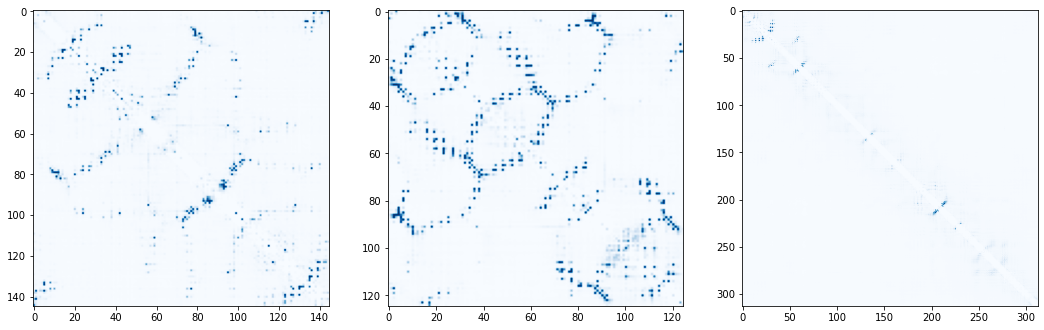

In [11]:
fig, axes = plt.subplots(figsize=(18, 6), ncols=3)
for ax, contact, sequence in zip(axes, esm1b_contacts, esm1b_batch_strs):
    seqlen = len(sequence)
    ax.imshow(contact[:seqlen, :seqlen], cmap="Blues")
plt.show()

## Run MSA Transformer Contact Prediction

In [12]:
msa_transformer, msa_alphabet = esm.pretrained.esm_msa1_t12_100M_UR50S()
msa_transformer = msa_transformer.eval().cuda()
msa_batch_converter = msa_alphabet.get_batch_converter()

In [13]:
msa_data = [
    read_msa("1a3a_1_A.a3m", 64),
    read_msa("5ahw_1_A.a3m", 64),
    read_msa("1xcr_1_A.a3m", 64),
]
msa_batch_labels, msa_batch_strs, msa_batch_tokens = msa_batch_converter(msa_data)
msa_batch_tokens = msa_batch_tokens.cuda()
print(msa_batch_tokens.size(), msa_batch_tokens.dtype)  # Should be a 3D tensor with dtype torch.int64.

torch.Size([3, 64, 314]) torch.int64


In [14]:
print(len(esm1b_data[0][1]))
print(len(esm1b_data[1][1]))
print(len(esm1b_data[2][1]))
msa_batch_tokens.shape
msa_data[0][0][1]

145
125
313


'LFKLGAENIFLGRKAATKEEAIRFAGEQLVKGGYVEPEYVQAMLDREKLTPTYLGESIAVPHGTVEAKDRVLKTGVVFCQYPEGVRFGEEEDDIARLVIGIAARNNEHIQVITSLTNALDDESVIERLAHTTSVDEVLELLAGRK'

In [15]:
%%time
msa_contacts = msa_transformer.predict_contacts(msa_batch_tokens).cpu()

CPU times: user 6.58 s, sys: 404 ms, total: 6.99 s
Wall time: 1.43 s


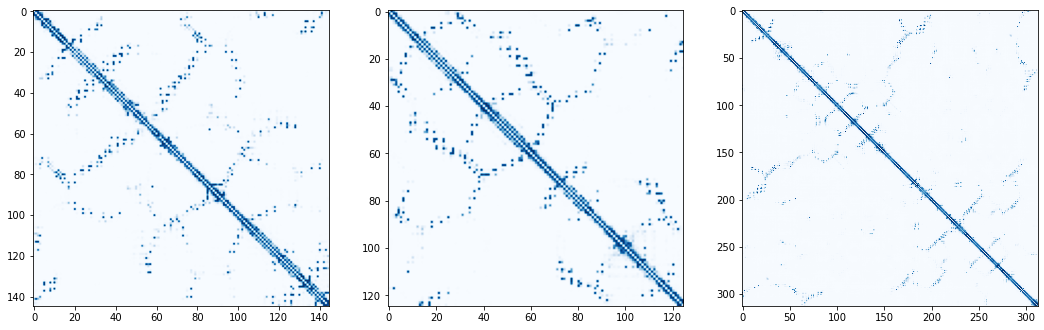

In [16]:
fig, axes = plt.subplots(figsize=(18, 6), ncols=3)
for ax, contact, msa in zip(axes, msa_contacts, msa_batch_strs):
    seqlen = len(msa[0])
    ax.imshow(contact[:seqlen, :seqlen], cmap="Blues")
plt.show()